In [89]:
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sqlalchemy import create_engine
import psycopg2
from imblearn.over_sampling import SMOTE
from collections import Counter
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.pipeline import Pipeline as imPipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [58]:
conn = psycopg2.connect(
    dbname="postgres", 
    user="root", 
    password="password1", 
    host="localhost", 
    port="5432"
)

# Define your SQL query
query = 'SELECT * FROM "Issue"'


# Execute the query and load the result into a DataFrame
df = pd.read_sql(query, conn)
column_mapping = {
    "Summary": "summary",
    "Issue key": "issueKey",
    "Issue id": "issueId",
    "Issue Type": "issueType",
    "Status": "status",
    "Project key": "projectKey",
    "Project name": "projectName",
    "Priority": "priority",
    "Resolution": "resolution",
    "Assignee": "assignee",
    "Reporter (Email)": "reporterEmail",
    "Creator (Email)": "creatorEmail",
    "Created": "created",
    "Updated": "updated",
    "Last Viewed": "lastViewed",
    "Resolved": "resolved",
    "Due date": "dueDate",
    "Description": "description",
    "Partner Names": "partnerNames",
    "Custom field (Cause of issue)": "causeOfIssue",
    "Custom field (Record/Transaction ID)": "recordTransactionId",
    "Custom field (Region)": "region",
    "Custom field (Relevant Departments)": "relevantDepartments",
    "Custom field (Relevant Departments).1": "relevantDepartments1",
    "Custom field (Request Category)": "requestCategory",
    "Custom field (Request Type)": "requestType",
    "Custom field (Request language)": "requestLanguage",
    "Custom field (Resolution Action)": "resolutionAction",
    "Satisfaction rating": "satisfactionRating",
    "Custom field (Satisfaction date)": "satisfactionDate",
    "Custom field (Source)": "source",
    "Custom field (Time to first response)": "timeToFirstResponse",
    "Custom field (Time to resolution)": "timeToResolution",
    "Custom field (Work category)": "workCategory",
    "Status Category": "statusCategory",
    "Status Category Changed": "statusCategoryChanged",
    "Custom field ([CHART] Date of First Response)": "dateOfFirstResponse",
    "comments": "comments"
}

# Rename the columns in the DataFrame
df.rename(columns=column_mapping, inplace=True)

/tmp/ipykernel_42658/836763382.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [60]:
df['initial_category'] = df['requestCategory'].str.split('->').str[0].str.strip()
df.dropna(subset=["requestCategory", "initial_category", "summary", "description", "requestType", "source", "causeOfIssue"], inplace=True)
print(len(df))

825


In [61]:

X = df[["summary", "description", "requestType", "source", "causeOfIssue"]]
y = df["initial_category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for text features and categorical features
text_transformer = TfidfVectorizer(stop_words="english", ngram_range=(1, 2), max_features=5000)
cat_transformer = OneHotEncoder(handle_unknown="ignore")

# Column transformer to apply preprocessing
preprocessor = ColumnTransformer([
    ("text_summary", text_transformer, "summary"),
    ("text_description", text_transformer, "description"),
    ("cat_features", cat_transformer, ["requestType", "source", "causeOfIssue"])
])

# Apply transformations to training data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Apply class balancing using SMOTE with filtering
class_counts = Counter(y_train)
min_samples = 6

# Find the minimum number of samples in any class
y_train_filtered = y_train[y_train.isin([k for k, v in class_counts.items() if v >= min_samples])]
X_train_filtered = X_train_transformed[y_train.isin([k for k, v in class_counts.items() if v >= min_samples])]

# Apply SMOTE
smote = SMOTE(sampling_strategy="auto", k_neighbors=min(min_samples - 1, 5), random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_filtered, y_train_filtered)

# Model Pipeline with Preprocessing and Classifier
model = Pipeline([
    ("preprocessor", preprocessor),  # Make sure preprocessing is applied at prediction time
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train Model on the resampled data
model.fit(X_resampled, y_resampled)

# Predictions on transformed test data (ensure that test data is preprocessed in the same way as training data)
y_pred = model.predict(X_test_transformed)

# Evaluation
print(classification_report(y_test, y_pred))

ValueError: Specifying the columns using strings is only supported for pandas DataFrames

Possible Model: 

In [62]:

X = df[["summary", "description", "requestType", "source", "causeOfIssue"]]
y = df["initial_category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# # Apply SMOTE to balance the classes
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Preprocessing
text_features = ["summary", "description"]
categorical_features = ["requestType", "source", "causeOfIssue"]

text_transformer = TfidfVectorizer(stop_words="english", max_features=5000)
cat_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer([
    ("text", text_transformer, "summary"),
    ("text2", text_transformer, "description"),
    ("cat", cat_transformer, categorical_features)
])

# Model Pipeline
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train Model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))

                               precision    recall  f1-score   support

        Agency Administration       0.80      0.33      0.47        12
             Billing / Grants       0.75      0.60      0.67         5
            Delivery / Pickup       0.67      0.50      0.57        24
Feedback - Concern / Negative       0.00      0.00      0.00         4
                         Menu       1.00      0.50      0.67        10
        Orders - Pre delivery       0.75      0.94      0.84       100
        Partner Produce Limit       0.83      1.00      0.91         5
                  PartnerLink       0.00      0.00      0.00         4
             Spam / Duplicate       0.00      0.00      0.00         1

                     accuracy                           0.75       165
                    macro avg       0.53      0.43      0.46       165
                 weighted avg       0.72      0.75      0.71       165



/home/parker/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parker/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parker/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


With SMOTE:

In [54]:

X = df[["summary", "description", "requestType", "source", "causeOfIssue"]]
y = df["initial_category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for text features and categorical features
text_transformer = TfidfVectorizer(stop_words="english", ngram_range=(1, 2), max_features=5000)
cat_transformer = OneHotEncoder(handle_unknown="ignore")

# Column transformer to apply preprocessing
preprocessor = ColumnTransformer([
    ("text_summary", text_transformer, "summary"),
    ("text_description", text_transformer, "description"),
    ("cat_features", cat_transformer, ["requestType", "source", "causeOfIssue"])
])

# Apply transformations to training data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Apply class balancing using SMOTE with filtering
class_counts = Counter(y_train)
min_samples = 6

# Find the minimum number of samples in any class
y_train_filtered = y_train[y_train.isin([k for k, v in class_counts.items() if v >= min_samples])]
X_train_filtered = X_train_transformed[y_train.isin([k for k, v in class_counts.items() if v >= min_samples])]

# Apply SMOTE
smote = SMOTE(sampling_strategy="auto", k_neighbors=min(min_samples - 1, 5), random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_filtered, y_train_filtered)

# Model Pipeline with Preprocessing and Classifier
model = Pipeline([
    ("preprocessor", preprocessor),  # Make sure preprocessing is applied at prediction time
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train Model on the resampled data
model.fit(X_resampled, y_resampled)

# Predictions on transformed test data (ensure that test data is preprocessed in the same way as training data)
y_pred = model.predict(X_test_transformed)

# Evaluation
print(classification_report(y_test, y_pred))

ValueError: Specifying the columns using strings is only supported for pandas DataFrames

XGBoost Model: 

In [64]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["initial_category"])

# Split data into train and test sets
X = df[["summary", "description", "requestType", "source", "causeOfIssue"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert categorical variables to one-hot encoding
cat_transformer = OneHotEncoder(handle_unknown="ignore")
class_counts = Counter(y_train)
total_samples = len(y_train)
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

# Set up the text transformer (TfidfVectorizer)
text_transformer = TfidfVectorizer(stop_words="english", ngram_range=(1, 2), max_features=5000)

# Preprocessor with text and categorical features
preprocessor = ColumnTransformer([
    ("text", text_transformer, "summary"),
    ("text2", text_transformer, "description"),
    ("cat", cat_transformer, ["requestType", "source", "causeOfIssue"])
])

# XGBoost Pipeline
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(scale_pos_weight=list(class_weights.values()), eval_metric="mlogloss"))
])

# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
unique_classes = sorted(set(y_test) | set(y_pred))

# Print the classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_[unique_classes]))

/home/parker/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [11:11:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


                               precision    recall  f1-score   support

        Agency Administration       0.50      0.50      0.50        12
             Billing / Grants       0.50      0.20      0.29         5
            Delivery / Pickup       0.65      0.62      0.64        24
Feedback - Concern / Negative       0.00      0.00      0.00         4
                         Menu       0.80      0.80      0.80        10
        Orders - Pre delivery       0.87      0.95      0.91       100
        Partner Produce Limit       0.83      1.00      0.91         5
                  PartnerLink       0.50      0.25      0.33         4
             Spam / Duplicate       1.00      1.00      1.00         1

                     accuracy                           0.80       165
                    macro avg       0.63      0.59      0.60       165
                 weighted avg       0.77      0.80      0.78       165



/home/parker/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parker/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parker/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


XGBoost wit SMOTE:

In [77]:
X = df[["summary", "description", "requestType", "source", "causeOfIssue"]]
y = df["initial_category"]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert categorical variables to one-hot encoding
cat_transformer = OneHotEncoder(handle_unknown="ignore")
text_transformer = TfidfVectorizer(stop_words="english", ngram_range=(1, 2), max_features=5000)

# Check class distribution in the training data
class_counts = Counter(y_train)
print(f"Class distribution: {class_counts}")

# Handle classes with very few samples
min_samples_per_class = 6  # Adjust this threshold if needed

# Filter out classes with fewer than min_samples_per_class samples in y_train
valid_classes = [cls for cls, count in class_counts.items() if count >= min_samples_per_class]
valid_train_mask = y_train.isin(valid_classes)

# Apply the filter to both X_train and y_train
X_train = X_train[valid_train_mask]
y_train = y_train[valid_train_mask]

# Filter the same classes from y_test (optional)
valid_test_mask = y_test.isin(valid_classes)
X_test = X_test[valid_test_mask]
y_test = y_test[valid_test_mask]

# SMOTE to balance the classes
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Preprocessor for the text and categorical data
preprocessor = ColumnTransformer([
    ("text", text_transformer, "summary"),
    ("text2", text_transformer, "description"),
    ("cat", cat_transformer, ["requestType", "source", "causeOfIssue"])
])

# Label encoding
label_encoder = LabelEncoder()

# Re-fit the label encoder on the filtered y_train
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)  # This should work now

# Class balancing and pipeline
class_counts = Counter(y_train_encoded)
total_samples = len(y_train_encoded)
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

# XGBoost model with class weights
xgb_model = XGBClassifier(scale_pos_weight=list(class_weights.values()), eval_metric="mlogloss")

# Create a pipeline with SMOTE
model = imPipeline([
    ("preprocessor", preprocessor),  # Apply preprocessing steps first
    ("smote", smote),  # Then apply SMOTE to balance the classes
    ("classifier", xgb_model)
])

# Train Model
model.fit(X_train, y_train_encoded)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

Class distribution: Counter({'Orders - Pre delivery': 368, 'Delivery / Pickup': 86, 'Menu': 49, 'Agency Administration': 45, 'Partner Produce Limit': 35, 'PartnerLink': 29, 'Billing / Grants': 28, 'Feedback - Concern / Negative': 14, 'Spam / Duplicate': 4, 'Feedback - Positive': 1, 'Return Notification': 1})


/home/parker/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [11:20:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


                               precision    recall  f1-score   support

        Agency Administration       0.55      0.50      0.52        12
             Billing / Grants       0.60      0.60      0.60         5
            Delivery / Pickup       0.58      0.58      0.58        24
Feedback - Concern / Negative       0.00      0.00      0.00         4
                         Menu       0.70      0.70      0.70        10
        Orders - Pre delivery       0.88      0.92      0.90       100
        Partner Produce Limit       0.83      1.00      0.91         5
                  PartnerLink       0.33      0.25      0.29         4

                     accuracy                           0.78       164
                    macro avg       0.56      0.57      0.56       164
                 weighted avg       0.76      0.78      0.77       164



In [83]:
param_grid = {
    # 'classifier__n_jobs': [-1],  # Use all CPU cores
    'classifier__max_depth': [3, 5, 7],  # Test different tree depths
    'classifier__learning_rate': [0.01, 0.1, 0.3],  # Test different learning rates
    'classifier__n_estimators': [50, 100, 200],  # Test different numbers of trees
    # 'classifier__subsample': [0.8, 1.0],  # Test subsampling
    # 'classifier__colsample_bytree': [0.8, 1.0],  # Test column sampling
    # 'classifier__scale_pos_weight': [1, 2, 3],  # Test scale pos weight values
}

model = imPipeline([
    ("preprocessor", preprocessor),  # Apply preprocessing steps first
    ("smote", smote),  # Then apply SMOTE to balance the classes
    ("classifier", xgb_model)  # Classifier
])

# Set up the GridSearchCV
grid_search = GridSearchCV(
    model,
    param_grid,
    scoring='accuracy',  # You can also use 'f1_macro', 'precision', etc.
    cv=5,  # 5-fold cross-validation
    verbose=1,  # Show progress
    n_jobs=-1  # Use all available CPU cores for the grid search
)

# Train the grid search model
grid_search.fit(X_train, y_train_encoded)

# Best model and hyperparameters
best_model = grid_search.best_estimator_
print(f"Best hyperparameters: {grid_search.best_params_}")

# Predictions from the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

KeyboardInterrupt: 

Bert model: 


In [32]:
bert_model = SentenceTransformer("all-MiniLM-L6-v2")

# Convert text to embeddings
X_train_text = [summary + " " + description for summary, description in zip(X_train["summary"], X_train["description"])]
X_test_text = [summary + " " + description for summary, description in zip(X_test["summary"], X_test["description"])]

X_train_embeddings = bert_model.encode(X_train_text)
X_test_embeddings = bert_model.encode(X_test_text)

In [85]:
cat_transformer = OneHotEncoder(handle_unknown="ignore")
text_transformer = TfidfVectorizer(stop_words="english", ngram_range=(1, 2), max_features=5000)

# Handle other features (assuming categorical columns are ["requestType", "source", "causeOfIssue"])
preprocessor = ColumnTransformer([
    ("cat", cat_transformer, ["requestType", "source", "causeOfIssue"])
])

# Step 3: Combine embeddings with other features
# If you want to keep the other features, combine them with the embeddings
X_train_combined = np.hstack([X_train_embeddings, preprocessor.fit_transform(X_train).toarray()])
X_test_combined = np.hstack([X_test_embeddings, preprocessor.transform(X_test).toarray()])

# Step 4: Train an XGBoost model
xgb_model = XGBClassifier(eval_metric="mlogloss")

# Define the SMOTE pipeline
# smote = SMOTE(sampling_strategy='auto', random_state=42)
model = imPipeline([
    # ("smote", smote),  # Apply SMOTE to balance the classes
    ("classifier", xgb_model)  # XGBoost classifier
])

# Step 5: Train the model
model.fit(X_train_combined, y_train_encoded)

# Step 6: Predictions and evaluation
y_pred = model.predict(X_test_combined)
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 660 and the array at index 1 has size 654

In [91]:
bert_model = SentenceTransformer("all-MiniLM-L6-v2")

# Split data into features and target
X = df[["summary", "description", "requestType", "source", "causeOfIssue"]]
y = df["initial_category"]

# Encode the target labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Process the categorical variables using OneHotEncoder
categorical_columns = ["requestType", "source", "causeOfIssue"]
encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")

X_train_cat = encoder.fit_transform(X_train[categorical_columns])
X_test_cat = encoder.transform(X_test[categorical_columns])

# Combine the 'summary' and 'description' columns to create text embeddings
X_train_text = [summary + " " + description for summary, description in zip(X_train["summary"], X_train["description"])]
X_test_text = [summary + " " + description for summary, description in zip(X_test["summary"], X_test["description"])]

# Generate the text embeddings using the pre-trained BERT model
X_train_embeddings = bert_model.encode(X_train_text)
X_test_embeddings = bert_model.encode(X_test_text)

# Combine the text embeddings with the one-hot encoded categorical features
X_train_combined = np.hstack([X_train_embeddings, X_train_cat])
X_test_combined = np.hstack([X_test_embeddings, X_test_cat])

# Train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
xgb_model.fit(X_train_combined, y_train)

# Make predictions and evaluate the model
y_pred = xgb_model.predict(X_test_combined)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


/home/parker/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/parker/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:04:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7758


In [92]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, labels=np.unique(y_test)))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
                               precision    recall  f1-score   support

        Agency Administration       0.40      0.33      0.36        12
             Billing / Grants       0.80      0.80      0.80         5
            Delivery / Pickup       0.78      0.58      0.67        24
Feedback - Concern / Negative       0.00      0.00      0.00         4
          Feedback - Positive       0.67      0.40      0.50        10
                         Menu       0.81      0.96      0.88       100
        Orders - Pre delivery       0.80      0.80      0.80         5
        Partner Produce Limit       1.00      0.50      0.67         4
                  PartnerLink       0.00      0.00      0.00         1

                     accuracy                           0.78       165
                    macro avg       0.58      0.49      0.52       165
                 weighted avg       0.75      0.78      0.75       165

Confusion Matrix:
[[ 4  0  1  0  0  7  0  0  0]
 [ 

/home/parker/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 9, does not match size of target_names, 11
  warnings.warn(
/home/parker/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parker/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parker/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of labels (11).

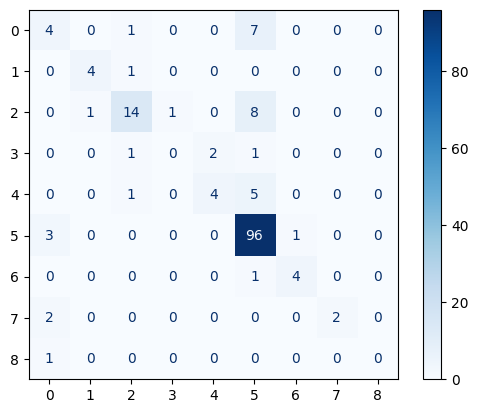

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
cm_display.plot(cmap='Blues')  # Optional: Choose a color map for better visibility
plt.show()
